## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Хренов |
|---------|--------|
| Группа  | 307      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
#!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
#!gzip -d mnist.pkl.gz

Теперь загружаем датасет:

In [2]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [4]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

Реализация персептрона

In [6]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db
        
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [7]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

In [30]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
                
    def get_loss_acc(self,x,y,loss=CrossEntropyLoss()):
        p = self.forward(x)
        l = loss.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        return l,acc
                
    def train_epoch(self, X_train, y_train, loss=CrossEntropyLoss(), batch_size=20, lr=0.0001):
        for i in range(0,len(X_train),batch_size):
            xb = X_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]

            p = self.forward(xb)
            l = loss.forward(p,yb)
            dp = loss.backward(l)
            dx = self.backward(dp)
            self.update(lr)
            
    def train(self, n_ep, X_train, y_train, loss=CrossEntropyLoss(), batch_size=100, lr=0.0001):
        l_dots = []
        ac_dots = []
        for i in range(n_ep):
            self.train_epoch(X_train, y_train, loss=loss, batch_size=batch_size, lr=lr)
            l, acc = self.get_loss_acc(X_train,y_train)
            l_dots.append(l)
            ac_dots.append(acc)
            #print("loss={}, accuracy={}: ".format(l,acc))
            
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.plot(l_dots)
        ax1.set_title('loss')
        ax2.plot(ac_dots)
        ax2.set_title('accuracy')

Создаем и обучаем однослойный персептрон

loss=7.302955376246046, accuracy=0.8087775408670931: 
loss=5.464119697734153, accuracy=0.8379175550817342: 
loss=4.610831449283075, accuracy=0.8495380241648899: 
loss=4.051513722482921, accuracy=0.8579246624022744: 
loss=3.529504105839616, accuracy=0.8659559346126511: 
loss=3.233215567853068, accuracy=0.8700426439232409: 
loss=2.9406965376104894, accuracy=0.876226012793177: 
loss=2.685398498433134, accuracy=0.881272210376688: 
loss=2.51982448653255, accuracy=0.8852167732764747: 
loss=2.3764689123193623, accuracy=0.8861762615493959: 


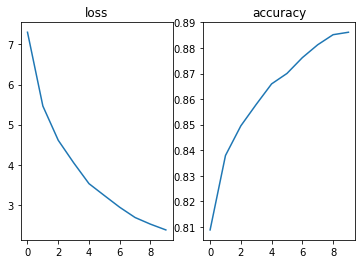

In [19]:
net = Net()
net.add(Linear(X_train.shape[1], 10))
net.add(Softmax())
loss = CrossEntropyLoss()
ep_num = 10
net.train(ep_num,X_train,y_train, lr=0.00007)

Матрица ошибок

In [22]:
from sklearn.metrics import confusion_matrix
p = net.forward(X_train)
pred = np.argmax(p,axis=1)
confusion_matrix(y_train, pred)

array([[2694,    0,   22,   14,    6,   16,   22,    4,   12,    9],
       [   0, 3018,   59,   13,    3,    9,    7,    9,   36,   10],
       [  21,   22, 2532,   34,   25,    7,   45,   34,   33,   10],
       [  21,   17,  174, 2410,    6,  116,   19,   26,   42,   49],
       [   6,   12,   26,    6, 2434,    6,   35,   18,   17,  154],
       [  58,   28,   53,   99,   29, 2076,   92,   18,   98,   39],
       [  18,    7,   30,    4,   21,   19, 2622,    3,   11,    5],
       [  11,   15,   47,   17,   29,    3,    5, 2626,    9,  159],
       [  42,   77,  195,   78,   22,  148,   47,   11, 2028,   81],
       [  16,   20,    6,   41,  114,   22,    5,  100,   19, 2497]],
      dtype=int64)

Результаты на тестовой выборке

In [23]:
print("loss={}, accuracy={}: ".format(*net.get_loss_acc(X_test,y_test)))

loss=3.2067520054072904, accuracy=0.8681096681096682: 


Создаем и обучаем многослойный персептрон

loss=0.9638205022825378, accuracy=0.7484363894811656: 
loss=0.700832769039131, accuracy=0.8214641080312722: 
loss=0.585336723026069, accuracy=0.8520255863539445: 
loss=0.5130417123935385, accuracy=0.868230277185501: 
loss=0.4624741244751005, accuracy=0.8808813077469794: 
loss=0.4281798606775536, accuracy=0.887135749822317: 
loss=0.40541027834226745, accuracy=0.894136460554371: 
loss=0.3775209490862789, accuracy=0.9021677327647477: 
loss=0.35946677840149854, accuracy=0.9040867093105899: 
loss=0.3384374772456423, accuracy=0.9092750533049041: 


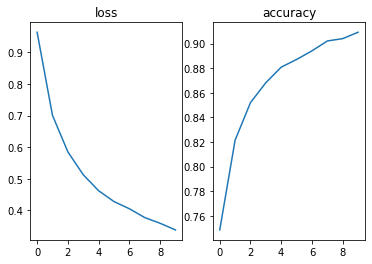

In [26]:
net = Net()
net.add(Linear(X_train.shape[1],100))
net.add(Tanh())
net.add(Linear(100,10))
net.add(Softmax())
loss = CrossEntropyLoss()
net.train(ep_num,X_train, y_train, lr=0.002)

Матрица ошибок

In [27]:
p = net.forward(X_train)
pred = np.argmax(p,axis=1)
confusion_matrix(y_train, pred)

array([[2697,    0,   14,    9,    3,   25,   20,    3,   25,    3],
       [   0, 3069,   15,   14,    2,   15,    6,    7,   27,    9],
       [  34,   18, 2432,   50,   39,    4,   60,   59,   49,   18],
       [  13,   14,   78, 2563,    2,   83,   17,   31,   55,   24],
       [   4,   14,   19,    3, 2516,    4,   33,    9,   13,   99],
       [  50,    8,   18,  120,   27, 2215,   44,   19,   60,   29],
       [  39,    7,   17,    1,   26,   35, 2604,    0,   11,    0],
       [  18,   15,   65,   18,   31,    7,    2, 2676,    5,   84],
       [  21,   37,   42,  116,   11,   82,   21,   18, 2332,   49],
       [  30,    7,   12,   37,  120,   24,    1,   91,   35, 2483]],
      dtype=int64)

Результаты на тестовой выборке

In [28]:
print("loss={}, accuracy={}: ".format(*net.get_loss_acc(X_test,y_test)))

loss=0.3751460575486384, accuracy=0.8974747474747474: 


Посмотрим, как на обучение влияет число нейронов в промежуточных сетях. Возьмем двухслойные сети с разными размерами промежуточных сетей.

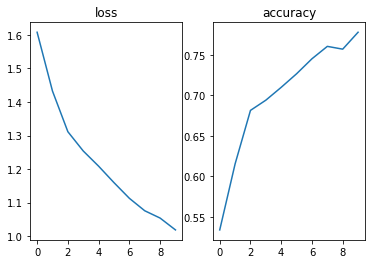

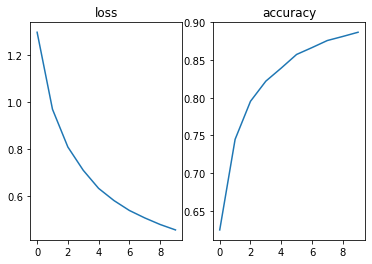

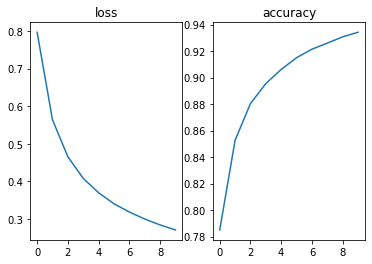

In [31]:
net1 = Net()
net1.add(Linear(X_train.shape[1],10))
net1.add(Tanh())
net1.add(Linear(10,10))
net1.add(Softmax())
loss = CrossEntropyLoss()
net1.train(ep_num,X_train, y_train, lr=0.001)

net2 = Net()
net2.add(Linear(X_train.shape[1],100))
net2.add(Tanh())
net2.add(Linear(100,10))
net2.add(Softmax())
net2.train(ep_num,X_train, y_train, lr=0.001)

net3 = Net()
net3.add(Linear(X_train.shape[1],1000))
net3.add(Tanh())
net3.add(Linear(1000,10))
net3.add(Softmax())
net3.train(ep_num,X_train, y_train, lr=0.001)

Чем больше число нейронов в промежуточных сетях, тем лучше проходит обучение и тем лучше финальная точность.